In [1]:
import numpy as np  # arrays
import matplotlib.pyplot as plt  # 2d plotting
from numpy.linalg import norm
from scipy.optimize import minimize_scalar #Exact line search algorithm

In [2]:
#Rosenbrock function
f = lambda x,y: (1-x)**2+100*(y-x**2)**2
Df = lambda x,y: np.array([2*(x-1)-400*x*y+400*x**3,
                           200*(y-x**2)])
D2f = lambda x,y: np.array([[2-400*y+1200*x**2,-400*x],
                            [-400*x,200]])

def objFunc(x): # Rosenbrock when the input is in vector form
    return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2
def gradObjFunc(x): # gradient of Rosenbrock
    return np.array([400*x[0]**3-400*x[0]*x[1]+2*x[0]-2, -200*x[0]**2+200*x[1]])

After 4811 iterations, approximate minimum is 1.2506650215602895e-16 at [1.00000001 1.00000002]


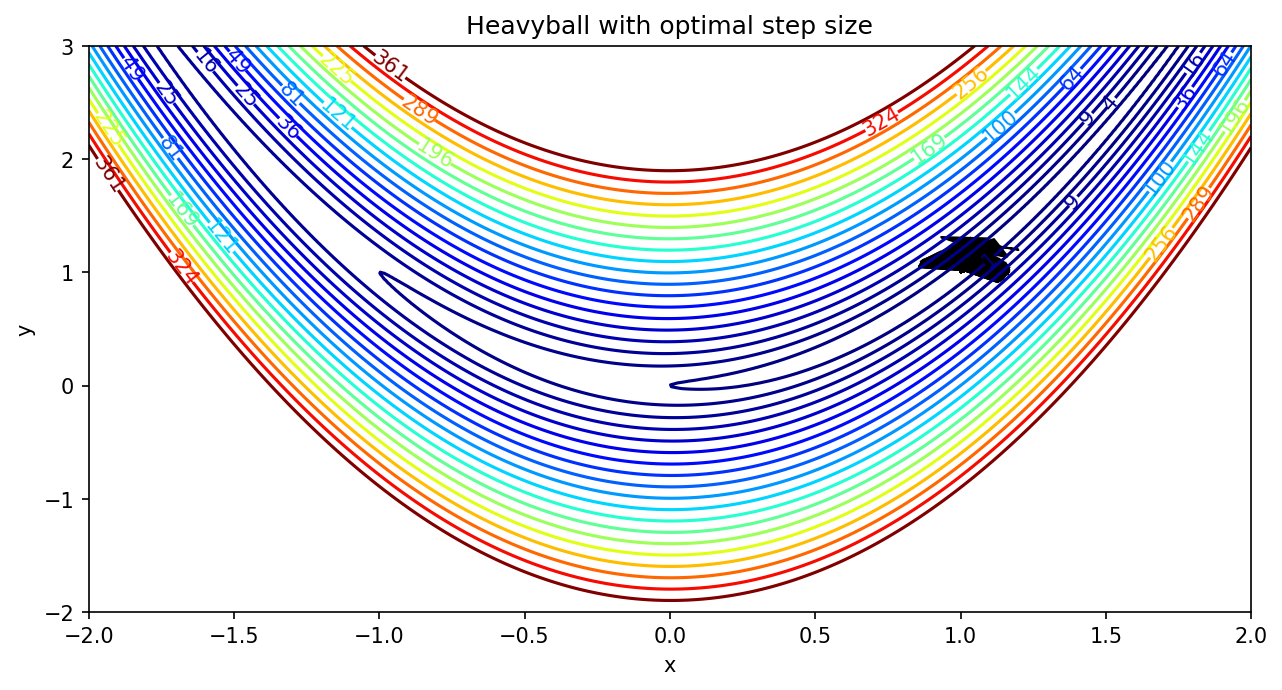

In [3]:
plt.figure(figsize=(10, 5), dpi=150)
X = np.linspace(-2,2,300)
Y = np.linspace(-2,3,300)
Xmesh, Ymesh = np.meshgrid(X,Y)
Z = f(Xmesh,Ymesh)
CS = plt.contour(Xmesh, Ymesh, Z, np.arange(1,20)**2, cmap='jet')
plt.clabel(CS,inline_spacing=0,fmt='%d')
plt.axis([-2,2,-2,3])
plt.xlabel('x')
plt.ylabel('y')

x = np.array([1.2,1.2])
tol = 1e-8
eigs, _ = np.linalg.eigh(D2f(1.2,1.2)) 
maxval = max(eigs)
minval = min(eigs)

# maxEig = 0
# minEig = 9999
# for i in np.linspace(1,1.2,20):
#     for j in np.linspace(1,1.2,20):
#         eigs, _ = np.linalg.eigh(D2f(i,j)) 
#        maxEig = max(maxEig, max(eigs))
#        minEig = min(minEig, min(eigs))
# We would get a negative minEig value in this way

alpha = 4 / (np.sqrt(minval) + np.sqrt(maxval))**2
beta = (np.sqrt(minval) - np.sqrt(maxval))**2 / (np.sqrt(minval) + np.sqrt(maxval))**2

max_steps = 5000
dx = Df(x[0],x[1])
pk = dx*0      # first update is just gradient descent
i=0
log_norm_gradient = [np.log(norm(dx))]
iteration = [i]
while np.linalg.norm(dx)>tol and i<max_steps:
    pk = dx + beta*pk
    xnew = x - alpha * pk
    plt.arrow(x[0],x[1],xnew[0]-x[0],xnew[1]-x[1],color='k', head_width=.1,length_includes_head=True)
    x = xnew
    i += 1
    dx = Df(x[0],x[1])
    iteration.append(i)
    log_norm_gradient.append(np.log(norm(dx)))

print(f'After {i} iterations, approximate minimum is {f(x[0],x[1])} at {x}')
plt.title('Heavyball with optimal step size')
plt.show()

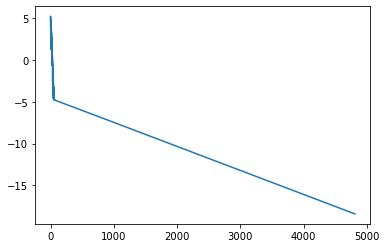

In [4]:
iteration = np.array(iteration)
log_norm_gradient = np.array(log_norm_gradient)
plt.plot(iteration,log_norm_gradient)

# Q2

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
data = np.loadtxt("CaCovidInfMarch24toMidJuly.txt")
X = np.arange(1, len(data) + 1) 
X_train = X[0:90]
X_valid = X[90:120]
y_train = data[0:90].reshape(90,1)
y_valid = data[90:120].reshape(30,1)

## Part a

In [50]:
A = np.c_[np.ones((90, 1)), X_train]
 # add x0 = 1 to each instance
x_best = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(y_train)
# solve normal equation
print(x_best)

model1 = lambda x: x_best[0] + x_best[1]*x

[[613.31244327]
 [ 30.17059661]]


## Part b

In [35]:
"""
@description: fixed step length steepest decent method
@parameters :
 @objFunc : objective function
 @gradObjFunc: gradient of objective function
 @alpha : the fixed step length, a.k.a. learning rate
 @x0 : starting point
 @tol : tolerace for stopping criteria
 @maxIter : maximum iteration for stopping criteria
"""
def fixed_step_steepest_descent_method(gradObjFunc, alpha, x0, tol,
maxIter):
  k = 0
  xk = x0
  pk = -gradObjFunc(x0)
  while np.linalg.norm(pk) > tol and k <= maxIter:
    xk = xk + alpha * pk 
    pk = -gradObjFunc(xk)
    k = k + 1

  if np.linalg.norm(pk) <= tol:
     print("Found the minimizer at {x} with {iter} iterations successfully, \
gradient's norm is {nrm}.".format(x=xk,iter=k,nrm=np.linalg.norm(pk)))
  else:
     print("Unable to locate minimizer within maximum iterations, last \
position is at {x}, gradient's norm is {nrm}".format(x=xk,nrm=np.linalg.norm(pk)))

  return xk, k

f = lambda theta: np.linalg.norm(A @ theta - y_train)**2
Df = lambda theta: A.T.dot(A.dot(theta) - y_train)
D2f = lambda theta: A.T.dot(A)
x0 = np.random.randn(2,1)
coeffs, k = fixed_step_steepest_descent_method(Df, 0.000004, x0, 1e-8, 5000)

Unable to locate minimizer within maximum iterations, last position is at [[220.01481418]
 [ 36.68992555]], gradient's norm is 8701.329767902062


In [83]:
eta = 0.000004
n_iterations=5000
theta = np.random.randn(2,1) #random start

for iteration in range(n_iterations):
    gradients = A.T.dot(A.dot(theta) - y_train)
    theta = theta - eta * gradients

model2 = lambda x: theta[0] + theta[1]*x
print(theta)

[[219.82736775]
 [ 36.69303268]]


## Part c

In [86]:
def minibatch_gradient_descent(X_b, y, n_iterations, minibatch_size, t0=2, t1=50000):
    theta_path_mgd = []
    np.random.seed(42)
    m = len(X_b)
    theta = np.random.randn(2,1) # random initialization
    def learning_schedule(t): # Learning rate
        return t0 / (t + t1)
    t = 0
    for epoch in range(n_iterations):
        shuffled_indices = np.random.permutation(m)
        X_b_shuffled = X_b[shuffled_indices]
        # shuffle/randomize indices towards iid samples
        # to improve settling down towards convergence
        y_shuffled = y[shuffled_indices]
        for i in range(0, m, minibatch_size):
            t += 1
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
            eta = learning_schedule(t)
            theta = theta - eta * gradients
            theta_path_mgd.append(theta)
    return theta,theta_path_mgd

theta,theta_path_mgd = minibatch_gradient_descent(A, y_train, 5000, 10)
model3 = lambda x: theta_path_mgd[-1][0] + theta_path_mgd[-1][1]*x
print(theta_path_mgd[-1])

[[287.53447368]
 [ 35.47542782]]


## Part d

In [80]:
from sklearn.metrics import mean_squared_error
y_train_predict = model1(X_train)
y_val_predict = model1(X_valid)
train_errors = mean_squared_error(y_train, y_train_predict)
val_errors = mean_squared_error(y_valid, y_val_predict)
print(train_errors)
print(val_errors)

174636.09534284784
18174062.416765187


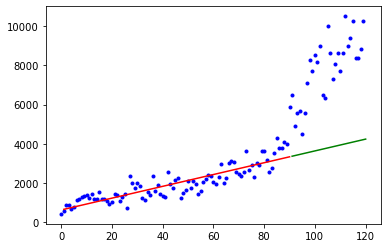

In [82]:
plt.plot(data,'b.',X_train,y_train_predict,'r',X_valid,y_val_predict,'g')

In [84]:
y_train_predict = model2(X_train)
y_val_predict = model2(X_valid)
train_errors = mean_squared_error(y_train, y_train_predict)
val_errors = mean_squared_error(y_valid, y_val_predict)
print(train_errors)
print(val_errors)

212702.1595791036
15785270.738831172


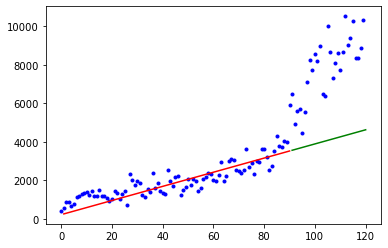

In [85]:
plt.plot(data,'b.',X_train,y_train_predict,'r',X_valid,y_val_predict,'g')

In [87]:
y_train_predict = model3(X_train)
y_val_predict = model3(X_valid)
train_errors = mean_squared_error(y_train, y_train_predict)
val_errors = mean_squared_error(y_valid, y_val_predict)
print(train_errors)
print(val_errors)

200753.81901119062
16261013.398611387


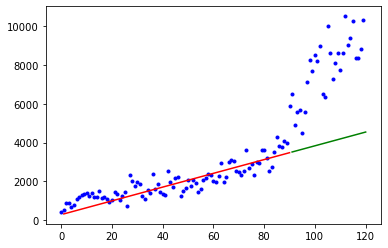

In [88]:
plt.plot(data,'b.',X_train,y_train_predict,'r',X_valid,y_val_predict,'g')

## Q3

In [106]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X_train.reshape(90,1)) # X_poly will be the matrix A

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_train)
lin_reg.intercept_, lin_reg.coef_

(array([1001.09376488]), array([[0.        , 4.88051042, 0.27791304]]))

In [121]:
model4 = lambda x: lin_reg.intercept_ + lin_reg.coef_[0][1]*x + lin_reg.coef_[0][2]*x**2

y_train_predict = model4(X_train)
y_val_predict = model4(X_valid)
train_errors = mean_squared_error(y_train, y_train_predict)
val_errors = mean_squared_error(y_valid, y_val_predict)
print(train_errors)
print(val_errors)

146501.07537748013
11693779.459501475


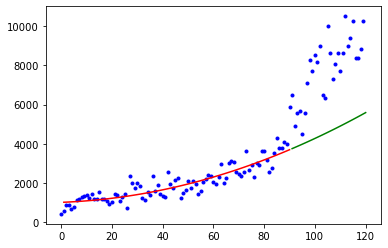

In [122]:
plt.plot(data,'b.',X_train,y_train_predict,'r',X_valid,y_val_predict,'g')

## Q4

In [123]:
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X_train.reshape(90,1)) # X_poly will be the matrix A

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_train)
lin_reg.intercept_, lin_reg.coef_

(array([653.08781856]),
 array([[ 0.00000000e+00,  4.95422479e+01, -9.42304168e-01,
          8.93932017e-03]]))

In [124]:
model5 = lambda x: lin_reg.intercept_ + lin_reg.coef_[0][1]*x + lin_reg.coef_[0][2]*x**2 + lin_reg.coef_[0][3]*x**3

y_train_predict = model5(X_train)
y_val_predict = model5(X_valid)
train_errors = mean_squared_error(y_train, y_train_predict)
val_errors = mean_squared_error(y_valid, y_val_predict)
print(train_errors)
print(val_errors)

131360.05818335962
4326620.564068805


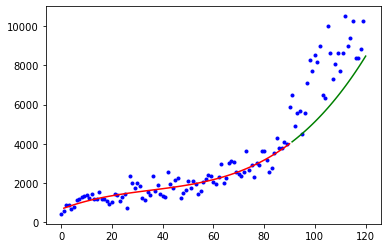

In [125]:
plt.plot(data,'b.',X_train,y_train_predict,'r',X_valid,y_val_predict,'g')

## Q5

The Best model for fitting this data is the cubic polynomial regression model from question 4. The data is clearly nonlinear, and it seems that the cubic model fits better than quadratic model.